# RNA - Atividade 2.1 - Perceptron de Rosenblatt

Neste projeto prático, o objetivo é implementar o algoritmo de treinamento mediante Aprendizado Supervisionado do neurônio Perceptron de Rosenblatt aplicado em problemas de classificação. Para tanto, cada equipe deverá elaborar Jupyter Notebooks com o código-fonte deste algoritmo de treinamento desenvolvido na linguagem de Programação Python e fazendo uso das bibliotecas numpy, random, math e matplotlib. Em particular, a biblioteca numpy será de uso obrigatório para todas as operações de natureza matricial (multiplicação de matrizes, produto escalar, etc). Neste projeto prático, a biblioteca sci-kit learn só deve ser utilizada para o cálculo de métricas de desempenho.

## Equipe

- Daniele Simas - 2015310060
- Felipe Amorim - 2115080033
- José Manuel - 2115080052
- Miguel Angelo - 2115080024

## Importação de Bibliotecas

In [381]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

import itertools

## Funções auxiliares

### Função de ativação
Arquivo original: `src/activation_functions.py`

In [382]:
def step_function(x: float) -> int:
    """
    Step activation function.

    Parameters:
        x (float): Input value.

    Returns:
        int: Output value (0 or 1).
    """
    return 1 if x >= 0 else 0

### Função para leitura dos arquivos de dados
Arquivo original: `src/utils.py`

In [383]:
def read_data(filename: str):
    # Read data from file
    data = np.fromfile(f"./task/data/data{filename}.txt")

    # Separate values into (x1 x2 y) elements
    data = data.reshape(-1, 3)

    # Reorganize valkues into [([x1.1,x1.2], y1), ([x2.1,x2.2], y2)]
    data = np.array([(row[:2], row[2]) for row in data], dtype=object)

    return data

### Função para calcular identificador da equipe
Arquivo original: `src/utils.py`

In [384]:
def identifier(values):
    # Pick last digit of each value
    last_digits = (int(value[-1]) for value in values)

    # Sum the digits
    soma = sum(last_digits)

    # Calcutate the final result
    result = soma % 4

    return str(result)

### Função para dividir um vetor em duas partições
Arquivo original: `src/utils.py`

In [385]:
def train_test_split(data: np.ndarray, train_portion=0.7):
    # Make a copy from data
    copy = data.copy()

    # Shuffle the data
    np.random.shuffle(copy)

    # Calculate an edge for splitting
    edge = int(data.shape[0] * train_portion)

    # Return train and test portions respectively
    return copy[:edge], copy[edge:]

### Função para criar gráfico de pontos E linha de decisão do neurônio
Arquivo original: `src/utils.py`

In [386]:
def plot_results(x_data, y_data, weights=None, ax: Axes = None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))

    # Criar gráfico de dispersão dos pontos de entrada usando os parametros "data"
    class_0 = x_data[y_data == 0]
    class_1 = x_data[y_data == 1]   

    ax.scatter(class_0[:, 1], class_0[:, 2], color="red", marker="x", label="Classe 0")
    ax.scatter(class_1[:, 1], class_1[:, 2], color="blue", marker="o", label="Classe 1")

    # Criar gráfico de linha da reta x2 = -(w1/w2)x1 + (w0/w2) gerada pelo perceptron
    if weights is not None:
        w0, w1, w2 = weights

        x1_min = np.min(x_data[:, 1]) - 0.5
        x1_max = np.max(x_data[:, 1]) + 0.5
        x1_values = np.linspace(x1_min, x1_max, 2)

        x2_min = np.min(x_data[:, 2]) - 0.5
        x2_max = np.max(x_data[:, 2]) + 0.5
        ax.set_ylim(x2_min, x2_max)

        x2_values = -(w1 / w2) * x1_values + (w0 / w2)

        ax.plot(
            x1_values,
            x2_values,
            color="black",
            linestyle="-",
            linewidth=2,
            label="Linha de decisão",
        )

    # Adicionar títulos e legendas
    ax.set_title("Linha de Decisão e Pontos do Problema")

    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

    ax.grid(True)

### Função para criar o gráfico matriz confusão
Arquivo original: `src/utils.py`

In [387]:
def draw_matrix(real, predicted, title='Matriz de confusão'):
    cm = metrics.confusion_matrix(real, predicted)

    plt.figure(figsize=(8, 8))

    plt.title(title)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], '.2f').lstrip('0').rstrip('.00'),
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Classe prevista')
    plt.ylabel('Classe real')

    plt.colorbar(shrink=0.6)

    labels = np.sort(np.unique(real))
    ticks = range(len(labels))
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)

    plt.tight_layout()
    plt.show()

### Função para execução do treinamento com todas as combinações possíveis dos parametros de entrada:

Arquivo original: `src/_parte2.py`

In [388]:
def train_with_parameters(perceptron, rates, ranges):
    results = dict()

    for range_bounds, learning_rate in itertools.product(ranges, rates):
        perceptron.learning_rate = learning_rate

        results[(learning_rate, range_bounds)] = []

        for _ in range(10):
            perceptron.randomize_weights(-range_bounds, range_bounds + 0.1)

            # Train the perceptron
            epochs, updates = perceptron.train()

            # Save training results
            results[(learning_rate, range_bounds)].append(
                {
                    "epoch_count": epochs,
                    "update_count": updates,
                    "final_weights": perceptron.weights,
                }
            )

    return results

## Implementação do Perceptron
Arquivo original: `src/perceptron.py`

In [389]:
class Perceptron:
    def __init__(
        self,
        data: np.ndarray,
        activation_function=None,
        bias: float = -1,
        learning_rate: float = 0.1,
    ):
        """
        Initialize the Perceptron.

        Parameters:
            data (np.ndarray): The input data as a numpy array of tuples (input, output).
            activation_function (function, optional): The activation function. Defaults to None.
            bias (float, optional): The bias value. Defaults to -1.
            learning_rate (float, optional): The learning rate. Defaults to 0.1.
        """
        self.bias = bias
        self.learning_rate = learning_rate

        self.activation_function = (
            activation_function if activation_function else step_function
        )

        self._input_data = None
        self._output_data = None
        self._data = None
        self.data = data  # This will call the setter and initialize _input_data and _output_data

    @property
    def data(self):
        """
        Get the input and output data as a combined numpy array.

        Returns:
            np.ndarray: Combined input and output data.
        """
        return self._data

    @data.setter
    def data(self, value: np.ndarray):
        """
        Separate the input and output data into two numpy arrays.
        Prepends self.bias to input and sets the weight array length based on input data.

        Parameters:
            value (np.ndarray): The input data as a numpy array of tuples (input, output).
        """
        if not isinstance(value, np.ndarray):
            raise ValueError("Data must be a numpy array")

        if not all(len(i) == 2 for i in value):
            raise ValueError("Data must be a numpy array of tuples (input, output)")

        self._data = value

        self._input_data = np.array(
            [np.insert(item[0], 0, self.bias) for item in value]
        )
        self._output_data = np.array([item[1] for item in value])

        self.__init_weights()

    def __init_weights(self):
        """
        Initialize the weights array.
        """
        self.weights = np.zeros(len(self._input_data[0]))

    def randomize_weights(self, floor=-0.5, ceiling=0.5):
        """
        Set each value of the weight array to a random number between the given interval
        """
        self.weights = np.random.uniform(floor, ceiling, len(self.weights))

    @property
    def input_data(self) -> np.ndarray:
        """
        Get the input data.

        Returns:
            np.ndarray: Input data.
        """
        return self._input_data

    @property
    def output_data(self) -> np.ndarray:
        """
        Get the output data.

        Returns:
            np.ndarray: Output data.
        """
        return self._output_data

    def train(self, max_epochs: int = None):
        """
        Train the Perceptron. Stops on max_epochs or on convergence.

        Parameters:
            max_epochs (int, optional): Maximum number of training epochs. Defaults to None.

        Returns:
            (epoch, weight_updates): Number of epochs trained and the amount of updates applied to the weights array done.
        """
        self.weight_updates = 0
        last_weight_update = 0

        # Count the number of weight updates done in each epoch
        self.updates_per_epoch = []

        # Train for at maximum "max_epoch" epochs
        if max_epochs and max_epochs > 0:
            for epoch in range(max_epochs):
                self.__run_single_epoch()

                # No change means every value was correctly predicted and no more training is necessary
                if last_weight_update == self.weight_updates:
                    return epoch + 1, self.weight_updates

                last_weight_update = self.weight_updates
            return max_epochs, self.weight_updates

        # Train until done OR user decides to quit on multiple of 1000
        epoch = 0
        while True:
            self.__run_single_epoch()
            epoch += 1

            if epoch % 1000 == 0:
                choice = input(f"Trained for {epoch} epochs, continue? (y/n) ")

                if choice in "nN":
                    return epoch, self.weight_updates

            # No change means every value was correctly predicted and no more training is necessary
            if last_weight_update == self.weight_updates:
                return epoch, self.weight_updates

            last_weight_update = self.weight_updates

    def shuffle_train(self, max_epochs: int):
        """
        Train the Perceptron, shuffling the training data every epoch. Stops on max_epochs or on convergence.

        Parameters:
            max_epochs (int, optional): Maximum number of training epochs. Defaults to None.

        Returns:
            (epoch, weight_updates): Number of epochs trained and the amount of updates applied to the weights array done.
        """
        self.weight_updates = 0
        last_weight_update = 0

        # Count the number of weight updates done in each epoch
        self.updates_per_epoch = []

        # Train for at maximum "max_epoch" epochs
        for epoch in range(max_epochs):
            # The "data" setter resets the perceptron weights, so we must save them before shuffling
            current_weights = self.weights

            shuffled_data = self._data.copy()
            np.random.shuffle(shuffled_data)
            self.data = shuffled_data

            self.weights = current_weights

            self.__run_single_epoch()

            # No change means every value was correctly predicted and no more training is necessary
            if last_weight_update == self.weight_updates:
                return epoch + 1, self.weight_updates

            last_weight_update = self.weight_updates

        return max_epochs, self.weight_updates

    def predict(self, values: np.ndarray):
        """
        Predict the output for the given input values.

        Parameters:
            values (np.ndarray): Input values.

        Returns:
            Predicted output.
        """
        u = np.dot(values, self.weights)
        return self.activation_function(u)

    def __run_single_epoch(self):
        """
        Perform a single epoch of training.
        """

        update_count = 0
        for input_values, output_value in zip(self._input_data, self._output_data):

            y = self.predict(input_values)

            if y == output_value:
                continue

            error = output_value - y

            self.weights = self.weights + self.learning_rate * error * input_values
            update_count += 1

        self.weight_updates += update_count
        self.updates_per_epoch.append(update_count)

### Exemplo de uso

In [390]:
if __name__ == "__main__":
    # Example data: List of tuples (input, output)
    example_data = [(np.array([2, 2]), 1), (np.array([4, 4]), 0)]
    # Convert the list of tuples to a NumPy array
    example_data = np.array(example_data, dtype=object)

    # Initialize the Perceptron
    perceptron = Perceptron(data=example_data)
    perceptron.randomize_weights()

    # Check the weights
    print("Randomized weights:", perceptron.weights)

    # training
    epochs, updates = perceptron.train()

    # Looking at the results
    print(f"Finished training in {epochs} epochs with {updates} updates!")
    print("Final weights:", perceptron.weights)
    print("Adjusts done in each epoch:", perceptron.updates_per_epoch)


Randomized weights: [-0.408101   -0.08857942 -0.30386085]
Finished training in 9 epochs with 12 updates!
Final weights: [-0.808101   -0.08857942 -0.30386085]
Adjusts done in each epoch: [2, 1, 2, 1, 2, 1, 2, 1, 0]


# Parte 1 - Resolvendo um problema linearmente separável

Nesta parte, todas as equipes devem usar o arquivo `dataAll.txt` e construir o algoritmo de treinamento do neurônio perceptron para resolver o problema de classificação proposto.

In [391]:
data = read_data('All')

print("Quantidade de pontos lidos:", len(data))
print("Formato dos dados:", data.shape)
print("\nExemplos de dados:", *[(x, y) for x,y in data[:5]], sep='\n')

Quantidade de pontos lidos: 1000
Formato dos dados: (1000, 2)

Exemplos de dados:
(array([-363.7884,  244.1423]), 0.0)
(array([ 328.7572, -256.7658]), 1.0)
(array([-164.9827,  613.2164]), 0.0)
(array([536.5905, 764.9575]), 0.0)
(array([314.2297, 343.8375]), 0.0)


1. As equipes devem utilizar a função de ativação degrau com ϑ = 0;
2. O valor da taxa de aprendizado deve ser igual a η = 0,1;
3. O vetor inicial de pesos deve ter seus valores inicializados conforme uma variável aleatória de distribuição uniforme no intervalo, isto é, wi ∼ U (−0,5, + 0,5). O vetor inicial de pesos deve ser impresso no início da execução do algoritmo;

In [392]:
perceptron = Perceptron(data=data, activation_function=step_function, bias=-1, learning_rate=0.1)

print('Vetor de pesos inicial: ', perceptron.weights)

perceptron.randomize_weights(floor=-0.5, ceiling=0.501)
print('Vetor de pesos após a randomização: ', perceptron.weights)

Vetor de pesos inicial:  [0. 0. 0.]
Vetor de pesos após a randomização:  [-0.36444581  0.01855392  0.44418376]


4. A cada época deve ser indicado o número de ajustes feitos no vetor de pesos;
5. O algoritmo deve executar até a convergência, isto é, até que não haja erros para todos os exemplos presentes no conjunto de treinamento;
6. Ao final, deve-se imprimir:
    - A - O número total de ajustes no vetor de pesos;
    - B - O número de épocas até a convergência;
    - C - O gráfico contendo todos os exemplos do conjunto de dados e a reta que separa as classes obtida como resultado do treinamento do neurônio Perceptron. Respeitar o esquema de cores proposto inicialmente e apresentar a solução de maneira clara neste gráfico.

In [393]:
epoch, updates = perceptron.train()

print(*[f'Na epóca {index+1} foram realizados {count} ajustes.' for index, count in enumerate(perceptron.updates_per_epoch)], sep='\n')
print('Treinamento finalizado!')
print("---")
print('Quantidade de épocas até a convergência: ', epoch)
print('Quantidade de ajustes no vetor de pesos: ', updates)
print("Vetor de pesos final: ", perceptron.weights)


Na epóca 1 foram realizados 24 ajustes.
Na epóca 2 foram realizados 20 ajustes.
Na epóca 3 foram realizados 11 ajustes.
Na epóca 4 foram realizados 0 ajustes.
Treinamento finalizado!
---
Quantidade de épocas até a convergência:  4
Quantidade de ajustes no vetor de pesos:  55
Vetor de pesos final:  [  -0.86444581  323.42758392 -323.06665624]


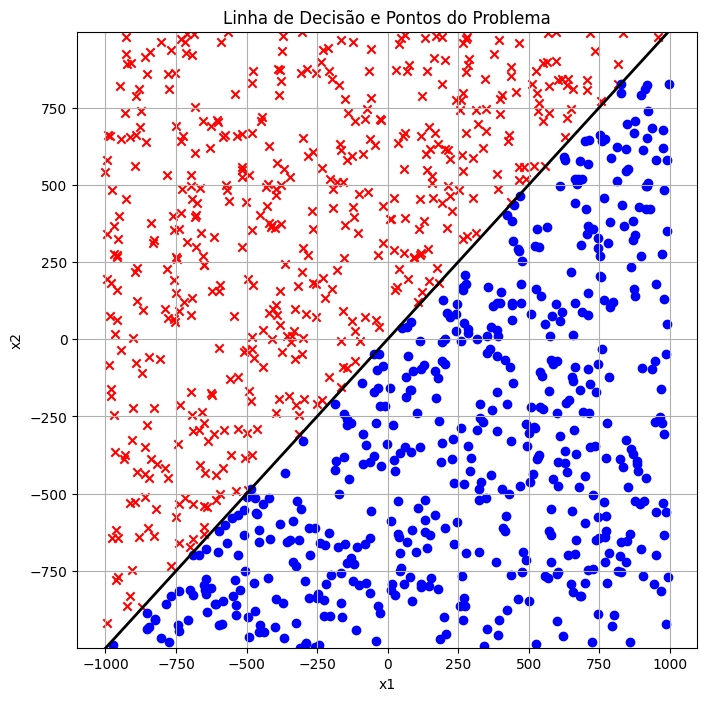

In [394]:
plot_results(perceptron.input_data, perceptron.output_data, perceptron.weights)

# Parte 2 - Experimentação

Nesta segunda parte, cada equipe deverá usar o seu respectivo identificador de exemplos para trabalhar com um arquivo específico.

In [395]:
matriculas = ["2015310060", '2115080033', "2115080052", "2115080024"]

team_id = identifier(matriculas)

print("Identificador da equipe:", team_id)

data = read_data(team_id)

print("Quantidade de pontos lidos:", len(data))
print("Formato dos dados:", data.shape)
print("\nExemplos de dados:", *[(x, y) for x,y in data[:5]], sep='\n')

Identificador da equipe: 1
Quantidade de pontos lidos: 600
Formato dos dados: (600, 2)

Exemplos de dados:
(array([ 0.13658687, -0.16460088]), 0.0)
(array([-0.0228559 , -0.01094684]), 0.0)
(array([-0.02654897,  0.00582183]), 0.0)
(array([0.07457416, 0.0650317 ]), 0.0)
(array([-0.01276975, -0.07384375]), 0.0)


A equipe deve aproveitar o algoritmo construído na Parte 1 e executar 10 repetições do mesmo para as seguintes configurações: η × I = {0.4, 0.1, 0.01} × {(−100, + 100), (−0.5, + 0.5)} em que I é o intervalo a ser utilizado para a distribuição uniforme do valor dos pesos. Assim, há 6 configurações a serem testadas, cada uma delas por 10 repetições.

In [396]:
perceptron = Perceptron(data)
rates = [0.4, 0.1, 0.01]
bounds = [100, 0.5]

results = train_with_parameters(perceptron, rates, bounds)

Para cada configuração, deve-se apresentar um único gráfico contendo as entradas e a solução obtida, para mostrar que todas as configurações, ainda que distintas, levam à convergência. O gráfico a ser mostrado pode conter a reta resultante da última repetição, por exemplo. É importante respeitar as sugestões de ilustração indicadas anteriormente.

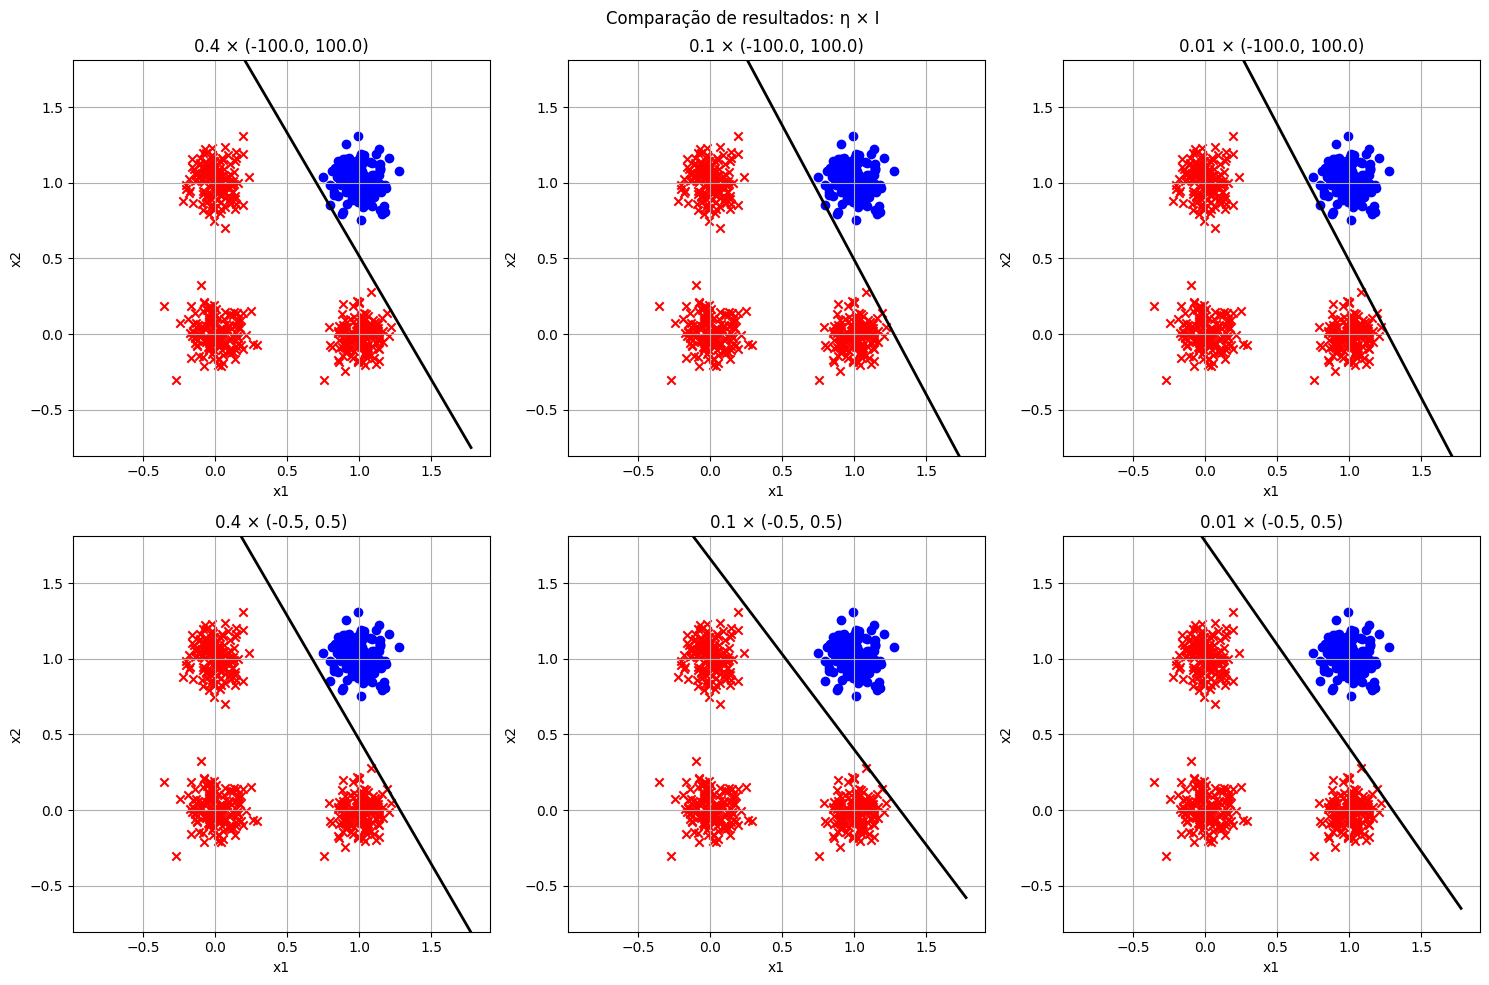

In [397]:
table = PrettyTable()
table.field_names = [
    "Taxa de Aprendizado",
    "Intervalo de Pesos",
    "Quantidade de Ajustes",
    "Menor número de épocas para convergência",
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, result in zip(axes.flat, results.items()):
    params, data = result
    learning_rate, bounds = params

    last_weight = data[-1]["final_weights"]

    mean_updates = np.mean([result["update_count"] for result in data])
    std_updates = np.std([result["update_count"] for result in data])
    min_epochs = np.min([result["epoch_count"] for result in data])

    table.add_row(
        [
            learning_rate,
            f"({-bounds:.1f}, {bounds:.1f})",
            f"{mean_updates:.1f} ± {std_updates:.1f}",
            min_epochs,
        ]
    )

    plot_results(perceptron.input_data, perceptron.output_data, last_weight, ax)
    ax.set_title(f"{learning_rate} × ({-bounds:.1f}, {bounds:.1f})")

fig.suptitle("Comparação de resultados: η × I ")
plt.tight_layout()
plt.show()

Para cada configuração em suas 10 execuções, obter a média e o desvio padrão da quantidade de ajustes efetuados no vetor de pesos e o menor número de épocas até a convergência nestas 10 iterações. Dispor tais resultados sobre a forma de uma tabela e discutir se há uma configuração melhor ou pior que as demais ou se elas são equivalentes. Uma estrutura para esta tabela é sugerida a seguir, a qual foi preenchida com dados fictícios. Recomenda-se a utilização do pacote prettytable no notebook.

In [398]:
table

Taxa de Aprendizado,Intervalo de Pesos,Quantidade de Ajustes,Menor número de épocas para convergência
0.4,"(-100.0, 100.0)",343.0 ± 164.8,6
0.1,"(-100.0, 100.0)",1226.0 ± 734.6,13
0.01,"(-100.0, 100.0)",15035.6 ± 6562.1,70
0.4,"(-0.5, 0.5)",40.8 ± 19.5,3
0.1,"(-0.5, 0.5)",27.3 ± 11.9,2
0.01,"(-0.5, 0.5)",71.0 ± 30.1,2


# Parte 3 - Validação Holdout em Problema Não-Linearmente Separável

Todas as equipes devem considerar o arquivo dataHoldout.txt e apresentar um gráfico inicial que
evidencie que este problema não é linearmente separável.

Quantidade de pontos lidos:  800
Formato dos dados:  (800, 2)

Exemplos de dados: 
(array([-0.29322959, -0.09065359]), 1.0)
(array([0.07988839, 0.21101297]), 1.0)
(array([-0.07825563, -0.08083512]), 1.0)
(array([-0.46833414, -0.10620722]), 1.0)
(array([0.46304142, 0.09405471]), 1.0)



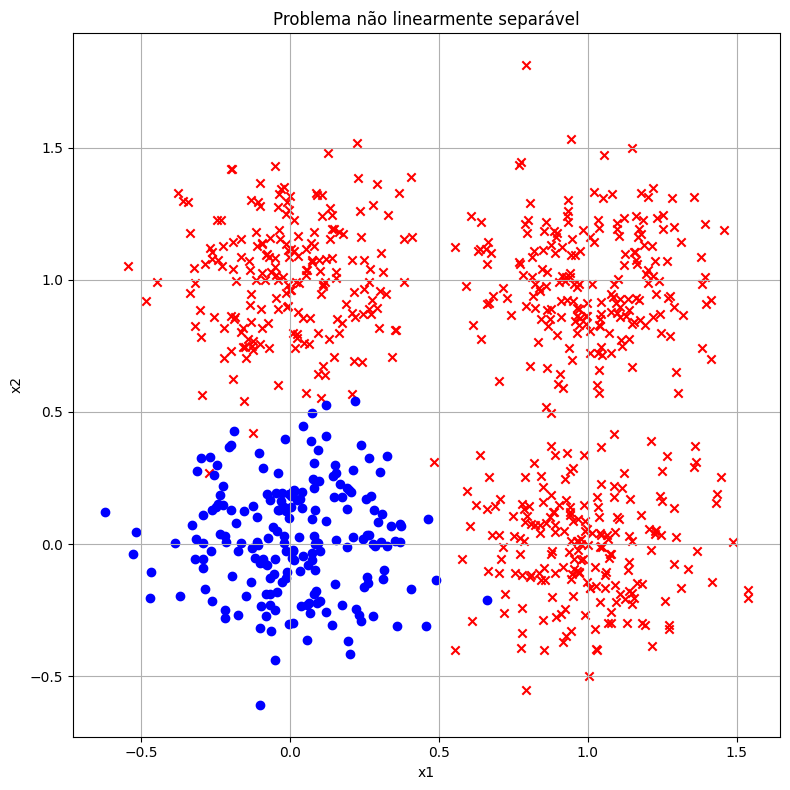

In [399]:
data = read_data("Holdout")

print("Quantidade de pontos lidos: ", len(data))
print("Formato dos dados: ", data.shape)
print("\nExemplos de dados: ", *[(x, y) for x, y in data[:5]], sep="\n", end="\n\n")

auxiliary = Perceptron(data)

fig, ax = plt.subplots(figsize=(8, 8))
plot_results(auxiliary.input_data, auxiliary.output_data, ax=ax)
ax.set_title("Problema não linearmente separável")

plt.tight_layout()
plt.show()

Em seguida, os exemplos devem ser aleatoriamente divididos em duas partições, uma delas contendo 70% dos exemplos (treinamento) e outra contendo 30% (teste).

In [400]:
train_data, test_data = train_test_split(data)
print("Quantidade de pontos para treinamento: ", len(train_data))
print("Quantidade de pontos para teste: ", len(test_data))

Quantidade de pontos para treinamento:  560
Quantidade de pontos para teste:  240


Embora o problema não seja linearmente separável, vamos utilizar os dados de treinamento para obter uma reta de separação das classes com o neurônio Perceptron (solução possível). O neurônio em questão tem função de ativação degrau com ϑ = 0, os valores de η e de inicialização de pesos devem seguir as recomendações da literatura e os pesos do neurônio devem ser aleatoriamente escolhidos a partir de U (−0,5,+0,5).

In [401]:
perceptron = Perceptron(train_data)
perceptron.randomize_weights(floor=-0.5, ceiling=0.501)
print("Vetor de pesos após a randomização: ", perceptron.weights)

Vetor de pesos após a randomização:  [0.12188351 0.26698332 0.19051299]


Execute o algoritmo por 100 épocas, mas a cada época apresente os exemplos disponíveis com conjunto de treinamento em ordem aleatória.

In [402]:
epoch, updates = perceptron.shuffle_train(100)

print("\nTreinamento finalizado!")
print("Quantidade de épocas treinadas: ", epoch)
print("Quantidade de ajustes no vetor de pesos: ", updates)
print("Quantidade de ajustes em cada época: ", perceptron.updates_per_epoch)


Treinamento finalizado!
Quantidade de épocas treinadas:  100
Quantidade de ajustes no vetor de pesos:  3286
Quantidade de ajustes em cada época:  [55, 33, 28, 25, 36, 38, 36, 27, 31, 29, 35, 35, 33, 38, 35, 37, 34, 32, 33, 30, 37, 38, 28, 35, 31, 30, 37, 31, 40, 24, 32, 31, 27, 34, 33, 32, 34, 31, 32, 33, 29, 32, 35, 38, 36, 28, 29, 38, 31, 26, 35, 26, 32, 34, 34, 37, 36, 32, 33, 31, 37, 34, 36, 29, 38, 32, 33, 35, 31, 29, 28, 35, 34, 30, 30, 30, 40, 32, 27, 36, 33, 31, 28, 37, 35, 35, 38, 29, 35, 31, 30, 29, 34, 34, 31, 35, 31, 30, 29, 33]


Efetue a previsão da saída deste neurônio para todos os exemplos do conjunto de teste, comparando-a com a saída desejada e responda ao que se pede:

In [403]:
auxiliary.data = test_data

predictions_test = []
for test in auxiliary._input_data:
    predictions_test.append(perceptron.predict(test))

In [404]:
predictions_train = []
for train in perceptron._input_data:
    predictions_train.append(perceptron.predict(train))

1. Apresente a matriz de confusão das previsões efetuadas para o conjunto de testes;

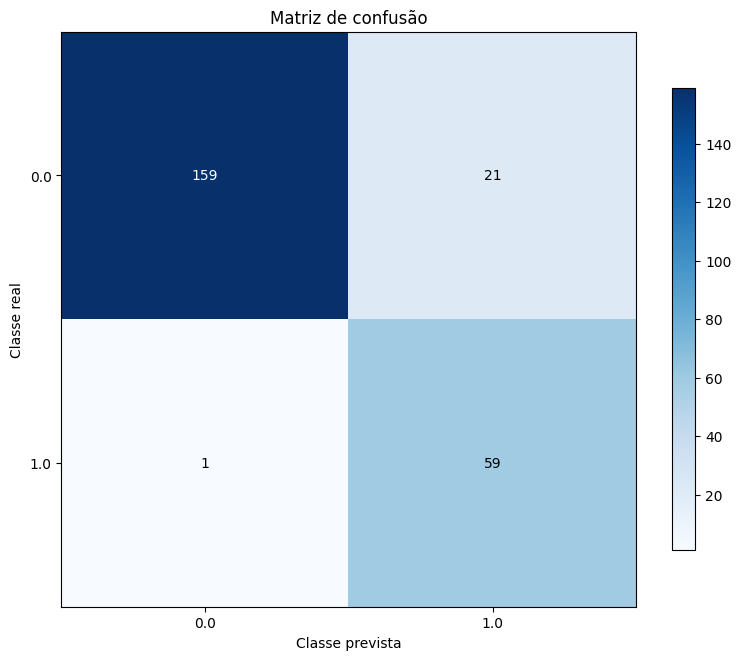

In [405]:
draw_matrix(auxiliary._output_data,predictions_test)



2. Qual a acurácia da solução proposta para os dados do conjunto de treinamento inicialmente fornecido?

In [406]:
accuracy = accuracy_score(perceptron._output_data, predictions_train)

print("Acurácia no conjunto de treinamento:", accuracy)

Acurácia no conjunto de treinamento: 0.8892857142857142


3. Nos mesmos termos da questão anterior, obtenha os valores de precisão, revocação e F-Score Para estes cálculos, está liberada a utilização de sklearn.metrics;

In [407]:
f1 = f1_score(perceptron._output_data, predictions_train)
recall = recall_score(perceptron._output_data, predictions_train)
precision = precision_score(perceptron._output_data, predictions_train)

print("F1-Score no conjunto de treinamento:", f1)
print("Revocação no conjunto de treinamento:", recall)
print("Precisão no conjunto de treinamento:", precision)

F1-Score no conjunto de treinamento: 0.8154761904761905
Revocação no conjunto de treinamento: 0.9785714285714285
Precisão no conjunto de treinamento: 0.6989795918367347


4. A partir destas métricas, discorra acerca da qualidade desta solução perante o conjunto de testes.

In [408]:
accuracy = accuracy_score(auxiliary._output_data, predictions_test)
f1 = f1_score(auxiliary._output_data, predictions_test)
recall = recall_score(auxiliary._output_data, predictions_test)
precision = precision_score(auxiliary._output_data, predictions_test)

print("Acurácia:", accuracy)
print("F1-Score:", f1)
print("Revocação:", recall)
print("Precisão:", precision)

Acurácia: 0.9083333333333333
F1-Score: 0.8428571428571429
Revocação: 0.9833333333333333
Precisão: 0.7375


Apresente dois gráficos com a solução obtida pelo neurônio Perceptron, mas um deles contendo os dados de treinamento e o outro contendo os dados de teste. Disponha tais gráficos lado a lado.

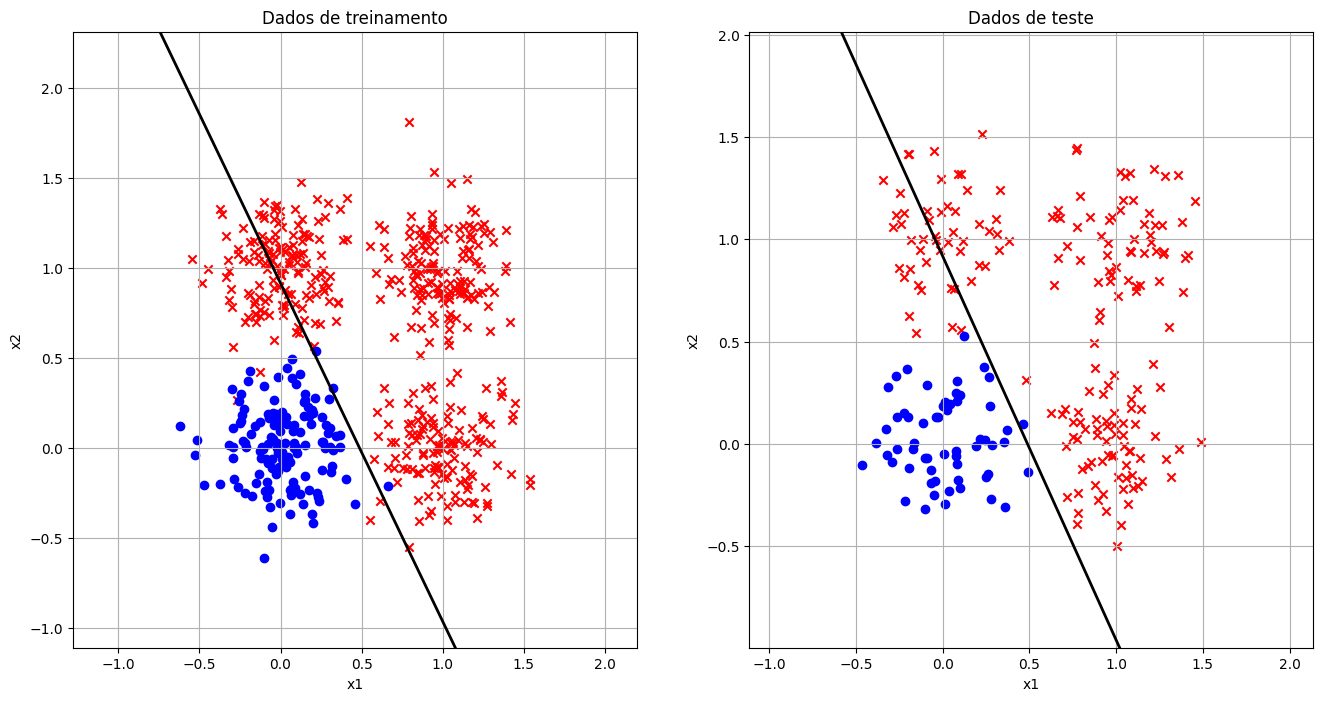

In [409]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax_train, ax_test = axes

plot_results(
    perceptron.input_data, perceptron.output_data, perceptron.weights, ax=ax_train
)
ax_train.set_title("Dados de treinamento")

plot_results(
    auxiliary.input_data, auxiliary.output_data, perceptron.weights, ax=ax_test
)
ax_test.set_title("Dados de teste")

plt.show()